In [12]:
# main.py

import backtrader as bt
import pandas as pd
from strategies.ma_strategy import MovingAverageStrategy
import matplotlib.pyplot as plt


In [13]:
# Data path
file_path = './data/BTCUSD.csv'

start_date = '2022-01-01T00:00:00+00:00'
end_date = '2022-05-03T05:19:00+00:00'

df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')

filtered_df = df.loc[start_date:end_date].copy()

filtered_df.rename(columns={'price': 'close'}, inplace=True)

# Ensure necessary columns exist
required_columns = {'open', 'high', 'low', 'close', 'volume'}
if not required_columns.issubset(filtered_df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")


In [14]:
SHORT_WINDOW = 500   # Short-term moving average
LONG_WINDOW = 2000   # Long-term moving average
INITIAL_CAPITAL = 10000  # Initial investment capital
POSITION_SIZE = 1.0  # Proportion of capital per trade

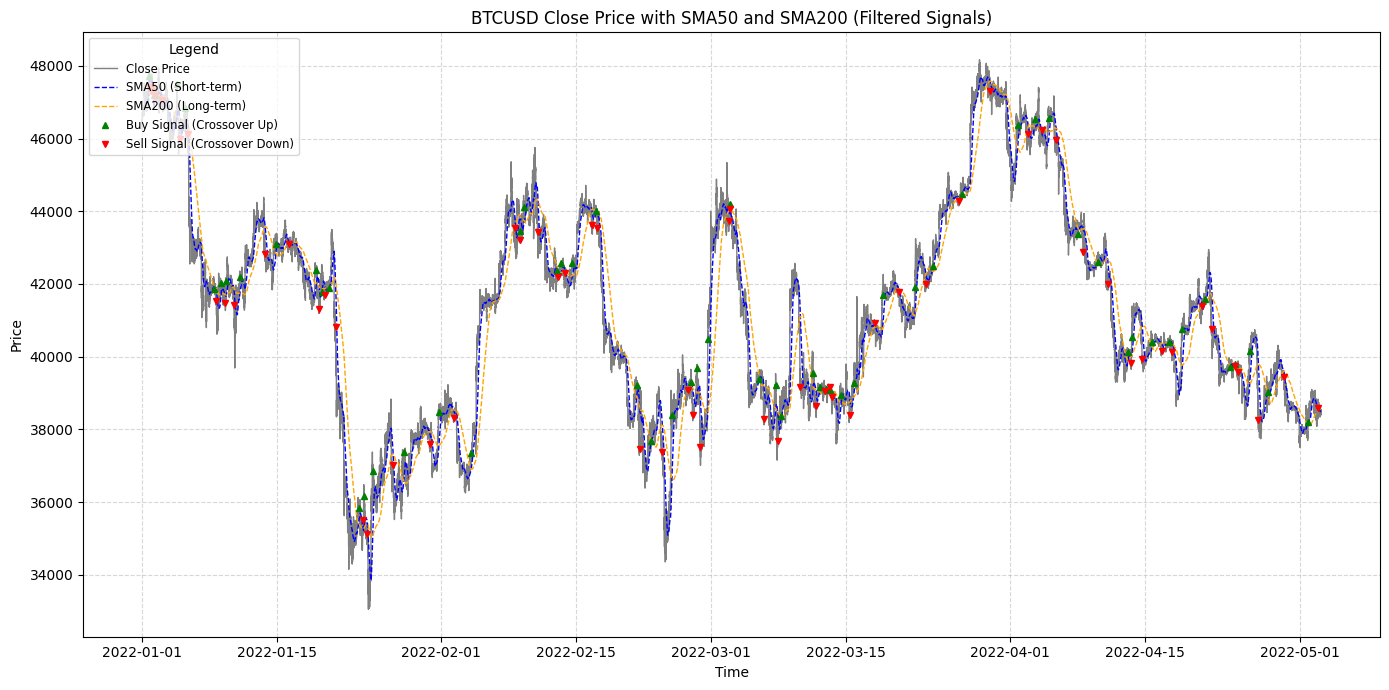

In [15]:


# Calculate moving averages
filtered_df['SMA50'] = filtered_df['close'].rolling(window=SHORT_WINDOW, min_periods=SHORT_WINDOW).mean()
filtered_df['SMA200'] = filtered_df['close'].rolling(window=LONG_WINDOW, min_periods=LONG_WINDOW).mean()

# Generate Buy/Sell Signals
filtered_df['Signal'] = 0  # Default to no position
filtered_df.loc[filtered_df['SMA50'] > filtered_df['SMA200'], 'Signal'] = 1  # Buy signal
filtered_df.loc[filtered_df['SMA50'] <= filtered_df['SMA200'], 'Signal'] = 0  # Sell signal

# Find where Signal changes (Buy to Sell or Sell to Buy)
filtered_df['Signal_Change'] = filtered_df['Signal'].diff()

# Plotting Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(filtered_df.index, filtered_df['close'], label='Close Price', linewidth=1, color='gray')
plt.plot(filtered_df.index, filtered_df['SMA50'], label='SMA50 (Short-term)', linestyle='--', linewidth=1, color='blue')
plt.plot(filtered_df.index, filtered_df['SMA200'], label='SMA200 (Long-term)', linestyle='--', linewidth=1, color='orange')

# Highlight Buy/Sell Only When Signal Changes
buy_signals = filtered_df[filtered_df['Signal_Change'] == 1]
sell_signals = filtered_df[filtered_df['Signal_Change'] == -1]

plt.plot(
    buy_signals.index,
    buy_signals['close'],
    '^', color='green', markersize=4, label='Buy Signal (Crossover Up)'
)
plt.plot(
    sell_signals.index,
    sell_signals['close'],
    'v', color='red', markersize=4, label='Sell Signal (Crossover Down)'
)

# Add Titles and Labels
plt.title('BTCUSD Close Price with SMA50 and SMA200 (Filtered Signals)')
plt.xlabel('Time')
plt.ylabel('Price')

# Add a Legend
plt.legend(
    loc='upper left',    # Place legend in the upper left corner
    fontsize='small',    # Use smaller font size for clarity
    title='Legend',      # Add a title to the legend
    title_fontsize='medium'  # Slightly larger title font
)

# Add Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Improve Layout
plt.tight_layout()
plt.show()


In [16]:
# Parameters
TRADE_FEE = 0.001  # Example: 0.1% trading fee per transaction

# Shift signal to prevent lookahead bias
filtered_df['Position'] = filtered_df['Signal'].shift(1)

# Backtest logic
filtered_df['Daily_Return'] = filtered_df['close'].pct_change()
filtered_df['Strategy_Return'] = filtered_df['Daily_Return'] * filtered_df['Position']

# Track Trades
filtered_df['Trade'] = (filtered_df['Position'].diff() != 0) & (~filtered_df['Position'].isna())
total_trades = filtered_df['Trade'].sum()

# Apply Trading Fee (Only When a Trade Happens)
filtered_df['Fee'] = 0
filtered_df.loc[filtered_df['Trade'], 'Fee'] = TRADE_FEE * INITIAL_CAPITAL

# Deduct Fees from Strategy Returns
filtered_df['Net_Return'] = filtered_df['Strategy_Return'] - (filtered_df['Fee'] / INITIAL_CAPITAL)

# Portfolio performance
filtered_df['Portfolio_Value'] = (1 + filtered_df['Net_Return']).cumprod() * INITIAL_CAPITAL

# Benchmark: Buy-and-Hold Strategy
initial_price = filtered_df['close'].iloc[0]
final_price = filtered_df['close'].iloc[-1]
buy_and_hold_return = final_price / initial_price
filtered_df['Benchmark_Value'] = INITIAL_CAPITAL * buy_and_hold_return

# Calculate Total Fees
total_transaction_fees = filtered_df['Fee'].sum()

# Calculate Relative Performance
strategy_final = filtered_df['Portfolio_Value'].iloc[-1]
benchmark_final = filtered_df['Benchmark_Value'].iloc[-1]

if strategy_final > benchmark_final:
    comparison = "outperformed"
else:
    comparison = "underperformed"

# Display Results
print(f"Final Portfolio Value (Strategy after Fees): ${strategy_final:.2f}")
print(f"Final Portfolio Value (Buy-and-Hold): ${benchmark_final:.2f}")
print(f"Number of Trades Executed: {total_trades}")
print(f"Total Transaction Fees Paid: ${total_transaction_fees:.2f}")
print(f"The strategy has {comparison} the Buy-and-Hold benchmark by ${strategy_final - benchmark_final:.2f}.")


Final Portfolio Value (Strategy after Fees): $7621.76
Final Portfolio Value (Buy-and-Hold): $8319.15
Number of Trades Executed: 127
Total Transaction Fees Paid: $1270.00
The strategy has underperformed the Buy-and-Hold benchmark by $-697.39.
